In [1]:
#import packages

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.resnet_v2 import ResNet101V2


In [2]:
# Import dataset

base_path = "C:/Users/psaik/Documents/CIP/"
lables = ["edible", "poisonous"]

# Directories containing images for each category
directory_group = [
    ['edible mushroom sporocarp', 'edible sporocarp'], 
    ['poisonous mushroom sporocarp', 'poisonous sporocarp']
]

# Lists to store file paths for each category
edible_fungus = []
poisonous_fungus = []

# Loop through each directory and add file paths to corresponding category list
for (label, directories) in zip(lables, directory_group):
    for directory in directories:
        items = os.listdir(base_path + directory)
        for item in items:
            file_path = base_path + directory + "/" + item
            if label == "edible":
                edible_fungus.append(file_path)
            else:
                poisonous_fungus.append(file_path)

# Remove duplicate file paths and convert to lists
edible_fungus = list(set(edible_fungus))
poisonous_fungus = list(set(poisonous_fungus))

# Define batch size and validation split
batch_size = 32
validation_split = 0.2

# Split data into training and validation sets
edible_fungus_split_index = int((1 - validation_split) * len(edible_fungus))
poisonous_fungus_split_index = int((1 - validation_split) * len(poisonous_fungus))
train_edible_fungus, valid_edible_fungus = edible_fungus[:edible_fungus_split_index],  edible_fungus[edible_fungus_split_index:] 
train_poisonous_fungus, valid_poisonous_fungus = poisonous_fungus[:poisonous_fungus_split_index],  poisonous_fungus[poisonous_fungus_split_index:] 

# Print number of training and validation samples for each category
print(len(train_edible_fungus), len(valid_edible_fungus))
print(len(train_poisonous_fungus), len(valid_poisonous_fungus))

# Calculate number of batches per epoch based on batch size
num_batch_per_epoch = min(len(train_edible_fungus), len(train_poisonous_fungus)) // batch_size
print(num_batch_per_epoch)

# Set number of epochs and convert data to numpy arrays
num_epochs = 50
train_edible_fungus = np.array(train_edible_fungus)
valid_edible_fungus = np.array(valid_edible_fungus)
train_poisonous_fungus = np.array(train_poisonous_fungus)
valid_poisonous_fungus = np.array(valid_poisonous_fungus)

# Calculate total number of validation samples
total_valid_count = len(valid_edible_fungus) + len(valid_poisonous_fungus)


944 237
1776 444
29


In [3]:
# Image Preprocessing function that reads and resizes images
def preprocess_image(item):
    # Read image file as a string
    image_string = tf.io.read_file(item[0])
    
    # Decode the image based on the file type using a conditional statement
    image_decoded = tf.cond(
        tf.image.is_jpeg(image_string),  # Check if the image is a JPEG
        lambda: tf.image.decode_jpeg(image_string, channels=3),  # Decode as JPEG, JPG
        lambda: tf.image.decode_png(image_string, channels=3)    # Decode as PNG
    )
    
    # Resize the decoded image
    image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Normalize the image pixels to be in the range [0, 1]
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    # Convert the label to an integer
    label = tf.strings.to_number(item[1], tf.int64)
    
    return image_normalized, label


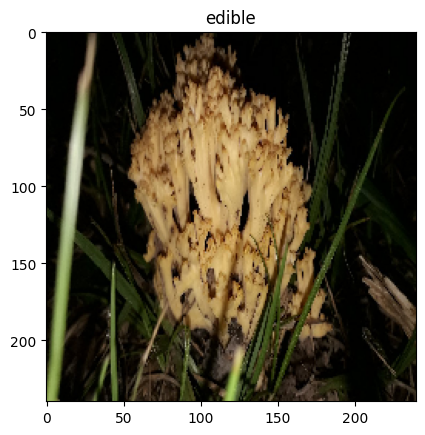

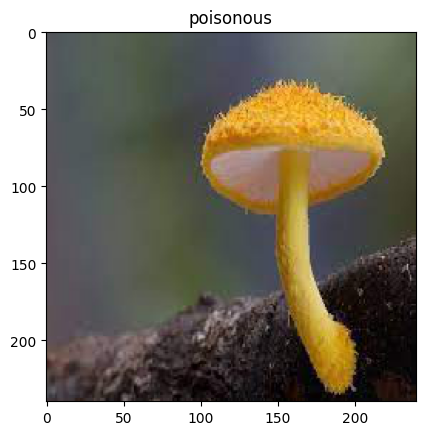

In [4]:
# Define a function to load and display an image from a file path
from PIL import Image
def show_image(file_path, category):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(240, 240)) # Load image and resize to 240x240 pixels
    plt.imshow(img) # Display the image
    plt.title(category)
    plt.show() # Show the plot

import random
random.seed(42) # Set a random seed for reproducibility

random.shuffle(edible_fungus) # Shuffle the list of edible fungus image file paths randomly
random.shuffle(poisonous_fungus)

show_image(edible_fungus[0], 'edible') 
show_image(poisonous_fungus[0], 'poisonous')

# from PIL import Image
# def show_image(file_path, category):
#     img = Image.open(file_path) # Load image using Pillow
#     img = img.resize((240, 240)) # Resize to 240x240 pixels
#     img.show() # External/Default image viewer
#     print(category)


In [5]:
# Get Tensorflow dataset for training and evaluation
# mode - train or eval, edible_fungus & poisonous_fungus - list of file paths
def get_dataset(edible_fungus, poisonous_fungus, mode, batch_size):
    # Combine into a single list
    x = list(edible_fungus) + list(poisonous_fungus)
    
    # Create a binary label for each mushroom indicating whether it is poisonous or not
    y = [0] * len(edible_fungus) + [1] * len(poisonous_fungus)
    
    # Combine the features and labels into a list of tuples
    items = [(a, b) for (a, b) in zip(x, y)]
    
    # Create a TensorFlow dataset from the list of tuples, shuffle the items randomly, and batch the data
    dataset = tf.data.Dataset.from_tensor_slices(np.array(items)).shuffle(len(x))
    dataset = dataset.map(preprocess_image).batch(batch_size)
    
    # Return the dataset
    return dataset

In [6]:
# Function to create a balanced dataset
def get_balanced_dataset(edible_fungus, poisonous_fungus, batch_count, batch_size, mode="train"):
    # Calc the number of samples per category
    length_per_category = batch_size * batch_count // 2
    # Randomly select indices of edible and poisonous fungi images
    edible_indices = np.random.choice(len(edible_fungus), length_per_category)
    poisonous_indices = np.random.choice(len(poisonous_fungus), length_per_category)
    # Calculate the total sample count
    sample_count = 2 * length_per_category
    # Create a balanced dataset with the selected edible and poisonous fungi images
    return get_dataset(
        edible_fungus[edible_indices], 
        poisonous_fungus[poisonous_indices], 
        mode, 
        batch_size
    ), sample_count


# Exploratory Data Analysis

In [7]:
len(edible_fungus)

1181

In [8]:
len(poisonous_fungus)

2220

In [9]:
edible_fungus[:10]

['C:/Users/psaik/Documents/CIP/edible sporocarp/ncvc (52).jpeg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (94).jpg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (430).jpg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (574).jpg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (407).jpg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (542).jpg',
 'C:/Users/psaik/Documents/CIP/edible sporocarp/ncvc (304).jpg',
 'C:/Users/psaik/Documents/CIP/edible sporocarp/ncvc (466).jpg',
 'C:/Users/psaik/Documents/CIP/edible sporocarp/ncvc (390).jpg',
 'C:/Users/psaik/Documents/CIP/edible mushroom sporocarp/ce (669).jpg']

# Model Development

In [ ]:
# Set the image size
IMAGE_SIZE = 240

# Set the name of the ResNet architecture to use
handle_base = "resnet_v2_101"

# Set the URL of the TensorFlow Hub module that provides the pre-trained ResNet feature extractor
MODULE_HANDLE = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5".format(handle_base)

# Create a Keras layer using the pre-trained ResNet feature extractor
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set the feature extractor to be non-trainable
feature_extractor.trainable = False
